In [1]:
#Imports
import sys
sys.path.append('../python/')
import NGC5533_functions_diskparam as nf

import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
import lmfit as lm
import dataPython as dp

In [2]:
#data = dp.getXYdata_wXYerr('data/NGC5533-rot-data_fmt.txt')
data = dp.getXYdata_wXYerr('data/100kpc_data.txt')
r_dat = np.asarray(data['xx'])
v_dat = np.asarray(data['yy'])
v_err0 = np.asarray(data['ex'])
v_err1 = np.asarray(data['ey'])

#change r_dat so it's strictly increasing
r_dat, v_dat, v_err0, v_err1 = (np.asarray(list(a)) for a in zip(*sorted(zip(r_dat, v_dat, v_err0, v_err1))))
#converting v_err1 to an array
v_err1_array = np.asarray(v_err1)

In [3]:
def f(r,M,rc,rho00,c,h,d_rho00,pref):
    return np.sqrt(nf.bh_v(r,M)**2 + nf.h_v(r,rc,rho00,load=True)**2 + c*nf.b_v(r,load=True)**2 + nf.d_v(r,h,d_rho00,pref,load=True)**2)

In [4]:
#Setup
weighdata = 1/v_err1
l_mod = lm.Model(f)
params = l_mod.make_params()
#Black Hole
params.add('M', value=nf.Mbh_def, min=0) #Mass
#Bulge
params.add('c', value=1, min=0)          #Contributions should all add
#params.add('n', value=nf.n_c, min=0) 
#params.add('re', value=nf.re_c, min=0) 
#Disk
params.add('h', value=nf.h_c, min=0)
params.add('d_rho00', value=nf.drho00_c, min=0)
params.add('pref', value=0.5, min=0)
#Halo
params.add('rc', value=nf.h_rc, min=0)   #Radius (magnitude)
params.add('rho00', value=nf.hrho00_c, min=0) #Density (halo)

#Do fit
l_fit = l_mod.fit(v_dat,params,r=r_dat,weights=weighdata)

#Define Stuff
l_dict = l_fit.best_values
l_M = l_dict['M']
l_rc = l_dict['rc']
l_hrho00 = l_dict['rho00']
l_h = l_dict['h']
l_drho00 = l_dict['d_rho00']
l_pref = l_dict['pref']
l_c = l_dict['c']
#l_n = l_dict['n']
#l_re = l_dict['re']

l_curve = np.sqrt(nf.bh_v(r_dat,l_M)**2 + nf.h_v(r_dat,l_rc,l_hrho00,load=True)**2 + l_c*nf.b_v(r_dat,load=True)[1]**2 + nf.d_v(r_dat,l_h,l_drho00,l_pref,load=True)**2)
    
b_curve = l_c*nf.b_v(r_dat,load=True)        #Bulge
d_curve = nf.d_v(r_dat,l_h,l_drho00,l_pref,load=True) #Disk
bh_curve = nf.bh_v(r_dat,l_M)                         #Black Hole
h_curve = nf.h_v(r_dat,l_rc,l_hrho00,load=True)       #Halo
#nodisk = np.sqrt(nf.bh_v(r_dat,l_M,load=True)**2 + nf.h_v(r_dat,l_rc,l_hrho00,load=True)**2 + l_c*nf.b_v(r_dat,l_n,l_re,load=True)**2)

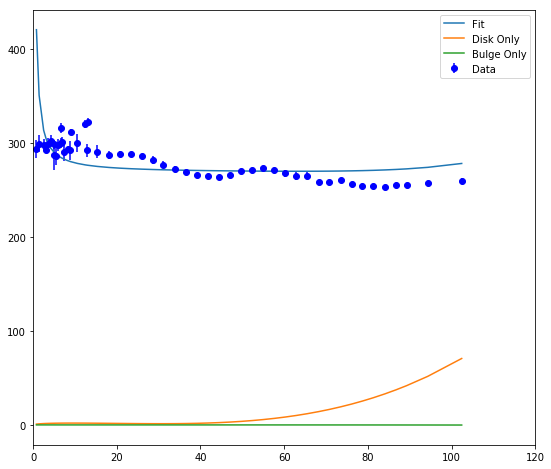

In [14]:
fig = plt.figure(figsize=(9.0,8.0))

plt.xlim(0,120)
#plt.ylim(0,450)

plt.errorbar(r_dat,v_dat,yerr=v_err1,fmt='bo',label='Data')
plt.plot(r_dat,l_curve,label='Fit')
plt.plot(r_dat,d_curve,label='Disk Only')
#plt.plot(r_dat,nodisk,label='No Disk')
plt.plot(r_dat,b_curve,label='Bulge Only')
#plt.plot(r_dat,bh_curve,label='Black Hole Only')
#plt.plot(r_dat,h_curve,label='Halo Only')

plt.legend()
plt.show()

l_fit

In [15]:
# Using fitted parameters to calculate parameters for Galactic Components
    
# Bulge
print('Bulge')
print('Scaling constant,         C = {:.2f}'.format(l_c))
#print('Concentration parameter,  n = {:.2f}'.format(l_n))
#print('Effective radius,         re = {:.2f} [kpc]'.format(l_re))

upsbulge = l_c * nf.b_r0(nf.n_c,nf.re_c) * nf.n_c / (4 * nf.G * nf.q * nf.b_I0(nf.n_c,nf.re_c) * (np.sqrt((np.sin(nf.i)**2)+(1/(nf.q**2))*(np.cos(nf.i)**2))))
print('Mass-to-Light Ratio,      upsdisk = {:.5e}'.format(upsbulge))

# comparing to fixed consants of re and n:
#ups2bulge = l_c * nf.b_r0(nf.n_c,nf.re_c) * nf.n_c / (4 * nf.G * nf.q * nf.b_I0(nf.n_c,nf.re_c) * (np.sqrt((np.sin(nf.i)**2)+(1/(nf.q**2))*(np.cos(nf.i)**2))))
#print('Mass-to-Light Ratio,      ups = {:.5e}'.format(ups2bulge))

#print(l_n)
#print(nf.n_c)
#print(l_re)
#print(nf.re_c)

print('')


# Disk
print('Disk')
print('Radial Scale Length,      h = {:.3f} [kpc]'.format(l_h))
print('Central Surface Density,  rho00 = {:.3e} [solar mass/kpc^3]'.format(l_drho00))
print('Scaling constant,         prefactor = {:.3f}'.format(l_pref))

r = (0.1, 125, 100)
upsdisk = l_pref * nf.d_Mdblintrho(r,nf.h_c,nf.drho00_c) / nf.L0
print('Mass-to-Light Ratio,      upsdisk = {:.5e}'.format(upsdisk))
print(nf.d_Mdblintrho(r,nf.h_c,nf.drho00_c))

print('')


# Black Hole
print('Black Hole')
print('Mass of the Black Hole,   M(bh) = {:.3e} [solar masses]'.format(l_M))
print('')


# Dark Halo
print('Dark Halo')
print('Halo central density,     rho00 = {:.3e} [solar mass/kpc^3]'.format(l_hrho00))
print('Core radius,              rc = {:.2f} [kpc]'.format(l_rc))


# Gas

Bulge
Scaling constant,         C = 0.00
Mass-to-Light Ratio,      upsdisk = 3.35123e-10

Disk
Radial Scale Length,      h = 8.941 [kpc]
Central Surface Density,  rho00 = 3.100e+08 [solar mass/kpc^3]
Scaling constant,         prefactor = 0.003
Mass-to-Light Ratio,      upsdisk = -1.16079e+05
-1.3539167495244508e+18

Black Hole
Mass of the Black Hole,   M(bh) = 2.907e+10 [solar masses]

Dark Halo
Halo central density,     rho00 = 3.654e+09 [solar mass/kpc^3]
Core radius,              rc = 0.60 [kpc]


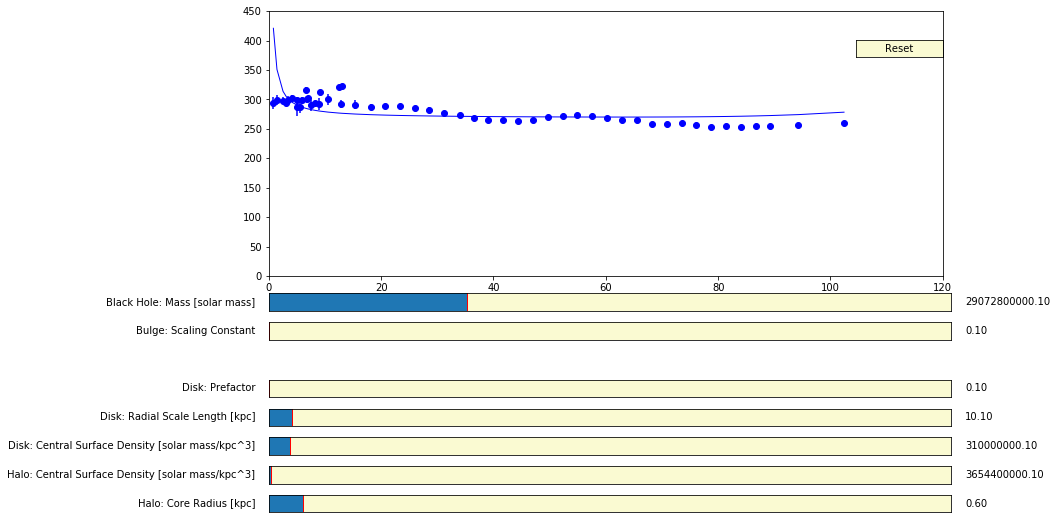

In [16]:
# Adding a slider to the plot using Matplotlib Slider Widget
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button, RadioButtons

fig, ax = plt.subplots(figsize=(12.0,8.0))
plt.subplots_adjust(left=0.12, bottom=0.42)
#fig = plt.figure(figsize=(9.0,8.0))

l, = plt.plot(r_dat, l_curve, linewidth=1, color='blue')
plt.errorbar(r_dat,v_dat,yerr=v_err1,fmt='bo',label='Data')
plt.axis([0, 120, 0, 450])

ax.margins(x=0)

axcolor = 'lightgoldenrodyellow'
ax_M = plt.axes([0.12, 0.36, 0.79, 0.03], facecolor=axcolor)  
ax_c = plt.axes([0.12, 0.31, 0.79, 0.03], facecolor=axcolor)
#ax_n = plt.axes([0.12, 0.31, 0.79, 0.03], facecolor=axcolor)
#ax_re = plt.axes([0.12, 0.26, 0.79, 0.03], facecolor=axcolor)
ax_pref = plt.axes([0.12, 0.21, 0.79, 0.03], facecolor=axcolor)
ax_h = plt.axes([0.12, 0.16, 0.79, 0.03], facecolor=axcolor)
ax_drho00 = plt.axes([0.12, 0.11, 0.79, 0.03], facecolor=axcolor)
ax_hrho00 = plt.axes([0.12, 0.06, 0.79, 0.03], facecolor=axcolor)
ax_rc = plt.axes([0.12, 0.01, 0.79, 0.03], facecolor=axcolor)

s_M = Slider(ax_M, 'Black Hole: Mass [solar mass]', 0.1, 1.0e11, valinit=l_M, valstep=1.0e5)
s_c = Slider(ax_c, 'Bulge: Scaling Constant', 0.1, 10.0, valinit=l_c, valstep=0.1)
#s_n = Slider(ax_n, 'Bulge: Concentration Parameter', 0.1, 20.0, valinit=l_n, valstep=0.1)
#s_re = Slider(ax_re, 'Bulge: Effective Radius [kpc]', 0.1, 300.0, valinit=l_re, valstep=5.0)
s_pref = Slider(ax_pref, 'Disk: Prefactor', 0.1, 10.0, valinit=l_pref, valstep=0.1)
s_h = Slider(ax_h, 'Disk: Radial Scale Length [kpc]', 0.1, 300.0, valinit=l_h, valstep=5.0)
s_drho00 = Slider(ax_drho00, 'Disk: Central Surface Density [solar mass/kpc^3]', 0.1, 1.0e10, valinit=l_drho00, valstep=1.0e5)
s_hrho00 = Slider(ax_hrho00, 'Halo: Central Surface Density [solar mass/kpc^3]', 0.1, 1.0e12, valinit=l_hrho00, valstep=1.0e5)
s_rc = Slider(ax_rc, 'Halo: Core Radius [kpc]', 0.1, 10.0, valinit=l_rc, valstep=0.1)

def update(val):
    u_M = s_M.val
    u_c = s_c.val
    #u_n = s_n.val
    #u_re = s_re.val
    u_pref = s_pref.val
    u_h = s_h.val
    u_drho00 = s_drho00.val
    u_hrho00 = s_hrho00.val
    u_rc = s_rc.val
    l.set_ydata(np.sqrt(nf.bh_v(r_dat,l_M)**2 + nf.h_v(r_dat,l_rc,l_hrho00,load=True)**2 + l_c*nf.b_v(r_dat,load=True)[1]**2 + nf.d_v(r_dat,l_h,l_drho00,l_pref,load=True)**2))
    #l.set_ydata(nf.bh_v(r_dat,l_M))
    fig.canvas.draw_idle()

s_M.on_changed(update)
s_c.on_changed(update)
#s_n.on_changed(update)
#s_re.on_changed(update)
s_pref.on_changed(update)
s_h.on_changed(update)
s_drho00.on_changed(update)
s_hrho00.on_changed(update)
s_rc.on_changed(update)

resetax = plt.axes([0.8, 0.8, 0.1, 0.03])
button = Button(resetax, 'Reset', color=axcolor, hovercolor='0.975')

def reset(event):
    s_M.reset()
    s_c.reset()
    #s_n.reset()
    #s_re.reset()
    s_pref.reset()
    s_h.reset()
    s_drho00.reset()
    s_hrho00.reset()
    s_rc.reset()
button.on_clicked(reset)

plt.show()